In [38]:
!pip install stellargraph[demos]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive 
import sys


drive.mount('/content/drive', force_remount=True) 
colab_path="/content/drive/My Drive/csci2470/project"
sys.path.append(colab_path)

Mounted at /content/drive


In [40]:
batch_size = 200
epochs = 20
train_size = 0.7
test_size = 0.3
num_samples = [8, 4]
num_workers = 4

In [41]:
# dataset = datasets.MovieLens()
# display(HTML(dataset.description))
# G, edges_with_ratings = dataset.load()
# print(G.info())

# user = pd.DataFrame(
#     {"duration": [2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4]},
#     index = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
# )

# subreddit = pd.DataFrame(
#     index = ["music", "drama", "game", "relation"]
# )

# join = pd.DataFrame(
#     {
#         "source": ["1", "1", "2", "3", "3", "4", "5", "6", "6", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"], 
#         "target": ["music", "drama", "music", "drama", "game", "game", "music", "music", "drama", "game", "music", "drama", "game", "relation", "music", "drama", "game", "relation", "music", "drama", "game", "relation", "game", "relation"],
#         "freq": [4, 8, 2, 12, 10, 4, 2, 4, 6, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 7, 8]
#      }
# )

# user = pd.DataFrame(
#     {"user_feat1": user_nodes['user_feat1'], "user_feat2": user_nodes['user_feat2']},
#     index = user_nodes['username'],
# )

# subreddit = pd.DataFrame(
#     {"subreddit_feat1": subreddit_nodes['subreddit_feat1']},
#     index = subreddit_nodes['subreddit'],
# )

In [42]:
pd.set_option('display.width', 100)

def u(users):
    return "u_" + users.astype(str)

def s(subreddits):
    return "s_" + subreddits.astype(str)

# data loading
user_nodes = pd.read_csv(f"{colab_path}/nodes_user_1000_mbti.csv")
subreddit_nodes = pd.read_csv(f"{colab_path}/nodes_subreddit_1000_keywords.csv")
edges = pd.read_csv(f"{colab_path}/edges_1000.csv")


# data clean up
user_nodes = user_nodes.drop(columns=['user_feat2', 'words'])
subreddit_nodes = subreddit_nodes.drop(columns=['subreddit_feat1', 'words'])
# edges = edges.drop(columns=['user_feat1', 'user_feat2', 'subreddit_feat1'])

# preprocessing
# user_nodes['username'] = u(user_nodes['username'])
# user_nodes.set_index("username", inplace=True)
user_ids = u(user_nodes['username'])
feature_encoding = preprocessing.OneHotEncoder(sparse=False)
onehot = feature_encoding.fit_transform(user_nodes[['mbti']])
user_nodes = pd.DataFrame(onehot, index=user_ids)


subreddit_nodes['subreddit'] = s(subreddit_nodes['subreddit'])
subreddit_nodes.set_index("subreddit", inplace=True)
genres = np.unique('|'.join(subreddit_nodes['genre']).split('|')).flatten().tolist()
subreddit_nodes = subreddit_nodes.reindex(subreddit_nodes.columns.tolist() + genres, axis=1, fill_value=0)
for index, row in subreddit_nodes.iterrows():
  for val in row.genre.str.split('|'):
      if val != 'NA':
        subreddit_nodes.loc[index, val] = 1
subreddit_nodes.drop('genre', axis=1, inplace=True)


edges["username"] = u(edges["username"])
edges["subreddit"] = s(edges["subreddit"])

# construct graph
G = sg.StellarGraph(
    {"user": user_nodes, "subreddit": subreddit_nodes},
    {"freq": edges[["username", "subreddit"]]},
    source_column="username",
    target_column="subreddit",
  )

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1599, Edges: 1000

 Node types:
  user: [945]
    Features: float32 vector, length 9
    Edge types: user-freq->subreddit
  subreddit: [654]
    Features: float32 vector, length 2410
    Edge types: subreddit-freq->user

 Edge types:
    subreddit-freq->user: [1000]
        Weights: all 1 (default)
        Features: none


In [43]:
edges_train, edges_test = model_selection.train_test_split(
    edges, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["username", "subreddit"]].itertuples(index=False))
edgelist_test = list(edges_test[["username", "subreddit"]].itertuples(index=False))

labels_train = edges_train["tot_comments"]
labels_test = edges_test["tot_comments"]


# edge_splitter_test = sg.data.EdgeSplitter(G)
# graph_test, edges_test, labels_test = edge_splitter_test.train_test_split(
#     p=0.2, method="global", edge_label="default"
# )

# edge_splitter_train = sg.data.EdgeSplitter(graph_test, G)
# graph_train, edges_train, labels_train = edge_splitter_train.train_test_split(
#     p=0.7, method="global", edge_label="default"
# )

generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "subreddit"]
)

train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('subreddit', [3]),
 ('subreddit', [4]),
 ('user', [5]),
 ('user', []),
 ('subreddit', [])]

In [44]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)
x_inp, x_out = hinsage.in_out_tensors()
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

import tensorflow.keras.backend as K

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

model.summary()

link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8, 2410)]    0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 32, 9)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 32, 2410)]   0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1, 9)]       0           []                               
     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 1s 33ms/step - loss: 2528.8960 - root_mean_square_error: 53.0207 - mean_absolute_error: 11.2057
Untrained model's Test Evaluation:
	loss: 2528.8960
	root_mean_square_error: 53.0207
	mean_absolute_error: 11.2057


Epoch 1/20
4/4 [==============================] - 5s 479ms/step - loss: 6237.1250 - root_mean_square_error: 68.5728 - mean_absolute_error: 15.7681 - val_loss: 2497.3513 - val_root_mean_square_error: 52.6954 - val_mean_absolute_error: 10.3015
Epoch 2/20
4/4 [==============================] - 1s 295ms/step - loss: 6201.6172 - root_mean_square_error: 78.1434 - mean_absolute_error: 15.3007 - val_loss: 2486.4126 - val_root_mean_square_error: 52.5817 - val_mean_absolute_error: 10.3067
Epoch 3/20
4/4 [==============================] - 2s 305ms/step - loss: 6187.1729 - root_mean_square_error: 78.9933 - mean_absolute_error: 15.3357 - val_loss: 2479.1079 - val_root_mean_square_error: 52.5052 - val_mean_absolute_error: 10.3577
Epoch 4/20
4/4 [==============================] - 2s 295ms/step - loss: 6174.7622 - root_mean_square_error: 64.7811 - mean_absolute_error: 15.3640 - val_loss: 2472.3804 - val_root_mean_square_error: 52.4348 - val_mean_absolute_error: 10.4387
Epoch 5/20
4/4 [================

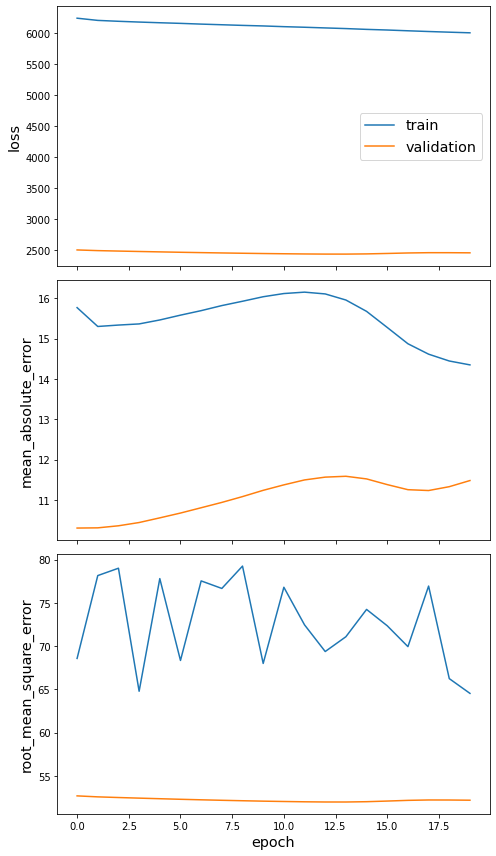

In [46]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

sg.utils.plot_history(history)

In [47]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 103ms/step - loss: 2450.5598 - root_mean_square_error: 52.1923 - mean_absolute_error: 11.4861
Test Evaluation:
	loss: 2450.5598
	root_mean_square_error: 52.1923
	mean_absolute_error: 11.4861
